# MaterialsCoord benchmarking – symmetry of bonding algorithms

Several near neighbor methods do not produce symmetrical bonding. For example, if site A is bonded to site B, it is not guaranteed that site B will be bonded to site A. In the MaterialsCoord benchmark we enforce symmetrical bonding for all algorithms. In this notebook, we assess how unsymmetrical the bonding is for each near neighbor method.

*Written using:*
- MaterialsCoord==0.2.0

*Authors: Alex Ganose (05/20/20)*

---

First, lets initialize the near neighbor methods we are interested in.

In [1]:
from pymatgen.analysis.local_env import BrunnerNN_reciprocal, EconNN, JmolNN, \
                                        MinimumDistanceNN, MinimumOKeeffeNN, MinimumVIRENN, \
                                        VoronoiNN, CrystalNN

nn_methods = [
    MinimumDistanceNN(),  MinimumOKeeffeNN(), MinimumVIRENN(), JmolNN(), 
    EconNN(tol=0.5), BrunnerNN_reciprocal(), VoronoiNN(tol=0.5), CrystalNN()
]

Next, import the benchmark and choose which structures we are interested in.

In [2]:
from materialscoord.core import Benchmark

structure_groups = ["common_binaries", "elemental", "A2BX4", "ABX3", "ABX4"]

bm = Benchmark.from_structure_group(structure_groups)

Enforcing symmetry always increases the number of assigned bonds. To assess the symmetry, we therefore calculate the number of additional bonds resulting from enforcing symmetrical bonding. Calculating the coordination number from a `StructureGraph` object (as returned by `NearNeighbors.get_bonded_structure()`) always enforces symmetry. In contrast, calculating the coordination number directly from the `NearNeighbors.get_cn()` method does not enforce symmetry.

In [23]:
import numpy as np
from tqdm.auto import tqdm

symmetry_results = []
no_symmetry_results = []

for nn_method in tqdm(nn_methods):
    nn_symmetry_cns = []
    nn_no_symmetry_cns = []
    
    for structure in bm.structures.values():
        bs = nn_method.get_bonded_structure(structure)
        
        for site_idx in range(len(structure)):
            nn_symmetry_cns.append(bs.get_coordination_of_site(site_idx))
            nn_no_symmetry_cns.append(nn_method.get_cn(structure, site_idx))

    symmetry_results.append(nn_symmetry_cns)
    no_symmetry_results.append(nn_no_symmetry_cns)

symmetry_results = np.array(symmetry_results)
no_symmetry_results = np.array(no_symmetry_results)

/Users/alex/miniconda3/envs/py3/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3955: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/Users/alex/miniconda3/envs/py3/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3749: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(


In [78]:
import pandas as pd

symmetry_totals = symmetry_results.sum(axis=1)
no_symmetry_totals = no_symmetry_results.sum(axis=1)

no_symmetry_norm = no_symmetry_totals / symmetry_totals
symmetry_extra = 1 - no_symmetry_norm

symmetry_df = pd.DataFrame(
    columns=[n.__class__.__name__ for n in nn_methods], 
    data=[no_symmetry_norm, symmetry_extra],
    index=["without symmetry", "with symmetry"]
)

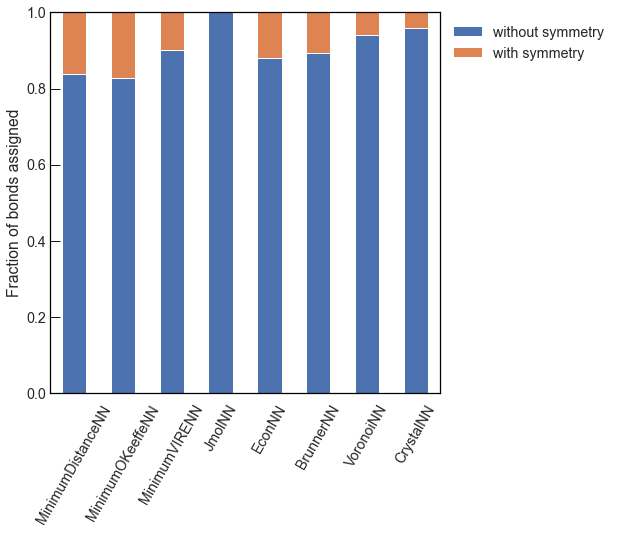

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set(font="Helvetica", font_scale=1.3, rc={"figure.figsize": (7, 7)})
sns.set_style("white", {"axes.edgecolor": "black", "axes.linewidth": 1.3})
plt.style.use({"mathtext.fontset": "custom", "mathtext.rm": "Arial",  "axes.grid.axis": "x"})

symmetry_df = symmetry_df.rename(columns={"BrunnerNN_reciprocal": "BrunnerNN"})
ax = symmetry_df.T.plot(kind='bar', stacked=True)

ax.set_xticklabels(symmetry_df.columns, rotation=60)
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
ax.set(ylabel="Fraction of bonds assigned", xlabel="", ylim=(0, 1))
ax.tick_params(axis='y', which='major', size=10, width=1, color='k', left=True, direction="in")

plt.savefig(Path("plots/symmetry.pdf"), bbox_inches="tight")
plt.show()

In [82]:
! open .